In [4]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import h,c,k
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import scienceplots
plt.style.use(['science','no-latex'])

#### Importing datasets

The following files contain data from the `COBE-FIRAS`(COBE- Far Infrared Absolute Spectrometer) instrument. This data is of the form:

* **Galactic Coordinates of the part of sky** : The sky here is divided into $6144$ pixels of which $6067$ (~$95$%) pixels are retrieved with sufficient measurements.

* **The Intensity of radiation received at that pixel** : There are $182$ values of Intensities measured in MJy/sr, across a set of frequencies. This analysis only considers data in the low-frequency band ($60-630$ GHz)   

In [5]:
data = fits.open('FIRAS_DESTRIPED_SKY_SPECTRA_LOWF.FITS')  
lowdust_data = fits.open("FIRAS_DUST_SPECTRUM_MAP_LOWF.FITS")

# Contents of the dataset

In [6]:
destriped_data=data[1].data
dust_data = lowdust_data[1].data
destriped_data.columns
dust_data.columns

ColDefs(
    name = 'PIXEL'; format = '1J'
    name = 'GAL_LON'; format = '1E'; unit = 'deg'
    name = 'GAL_LAT'; format = '1E'; unit = 'deg'
    name = 'WEIGHT'; format = '1E'
    name = 'SPECTRUM'; format = '182E'; unit = 'MJy/sr'; dim = '(182)'
)

# Getting best fit temperatures for every pixel

It is observed that all the pixels have $43$ workable intensity values. The data is fitted to a Planck Distribution  spectrum for blackbodies $$ I(v,T) = \frac{2hv^3}{c^2(e^{\frac{hv}{kT}}-1)} $$

In [7]:
def Intensity(freq,T):
    
    e=np.exp(h*freq/(k*T))
    return (2*h*freq**3)/(c**2*(e-1))*1e20  # 1e20 used to convert the units

Where, 
> h = Planck's constant ($6.62607015 \times 10^{-34}$ J/Hz) \
     k = Boltzmann's constant ($1.380649 \times 10^-23$ J/K) \
     c = speed of light in vacuum ($2.99792458 \times 10^8$ m/s)\
     v = frequency of the CMBR (Hz) \
     T = temperature of blackbody (K) 
    

There are 43 workable Frequency points for each pixel. The detector's initial captured frequency is `68.020812 GHz` with measuring interval of `13.604162 GHz`, putting the whole spectrum in the microwave region

In [8]:
freq_0=68.020812*1e9
freq_interval=13.604162*1e9
frequency=[]

for i in range(43):
    
    freq_flag=freq_0+i*freq_interval
    frequency.append(freq_flag)

frequency=np.array(frequency)

In the following function, ```scipy.optimize.curve_fit()``` is used to find best fit parameter (Temperature of the Planck Distribution) using advanced Linear Regression algorithms

In [9]:
def get_Temperature(frequency,input): # function to get best fit temperatures and uncertainties
    
    Pixel_data=dict()
    Pixel_data['Temperature']=[]
    Pixel_data['Uncertainty']=[]
    
    for i in range(len(input)):
    
        Intensity_observed=input[i]
        Intensity_observed=Intensity_observed[0:43:]
        
        T0=2.727754
        popt,pcov=curve_fit(Intensity,frequency,Intensity_observed,p0=[T0])
        
        Temperature_fit=popt[0]
        Uncertainty_fit=np.sqrt(np.diag(pcov))
        Pixel_data['Temperature'].append(Temperature_fit)
        Pixel_data['Uncertainty'].append(Uncertainty_fit)
    
    return Pixel_data


It'll be convenient to find the Root-Mean-Square of our data

In [10]:
def root_mean_square(input): # function to find rms of the data
    
    input=np.array(input)
    squared_input=input**2
    mean=np.mean(squared_input)

    return np.sqrt(mean)

We will use either this or the ```Pixel_data['Uncertainty']``` data, though i suppose we should use this because this method produces a little bit larger range of uncertainty

In [11]:
def uncertainty(input,mean):
    uncertainty_list = []
    
    for i in range(len(input)):
    
        if input[i] > mean:
          uncertainty_list.append(input[i] - mean) 
    
        else:
          uncertainty_list.append(mean - input[i])
    
    uncertainty_array = np.array(uncertainty_list)
    
    return(np.mean(uncertainty_array))

These functions automate calculating the averages and printing results

In [12]:
def Temperature_value(data1,data2):
    Temperature = root_mean_square(data1)
    Uncertainty = root_mean_square(data2) 
    print('Temperature attained is = {:.6f} +- {:.6f} K \n'.format(Temperature , Uncertainty))
    
def Temperature_value_control(data1,data2):
    Temperature = root_mean_square(data1)
    Uncertainty = root_mean_square(data2) 
    return print('Temperature_control attained is = {:.6f} +- {:.6f} K \n'.format(Temperature , Uncertainty))
  

`Pixel_data` is a dictionary in which temperatures and uncertainties are mapped to each other for all 6067 pixels

In [13]:
Pixel_data=get_Temperature(frequency,destriped_data['SPECTRUM'])
print(Temperature_value(Pixel_data['Temperature'],Pixel_data['Uncertainty']))

Temperature attained is = 2.729854 +- 0.002808 K 

None


As to check the goodness of fit, we'll try plotting Intensity vs Frequency for an arbitrary pixel

In [64]:
# pick any pixel from 0-6067

pix=5677

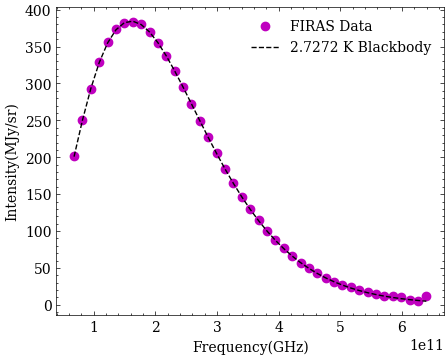

In [65]:
intensity=destriped_data['SPECTRUM'][pix]

plt.figure(figsize=(5,4))
plt.plot(frequency,intensity[0:43],'mo',label='FIRAS Data')
plt.plot(frequency,Intensity(frequency,Pixel_data['Temperature'][pix]),'k--',label=f"{Pixel_data['Temperature'][pix]:.4f} K Blackbody")
plt.xlabel('Frequency(GHz)')
plt.ylabel('Intensity(MJy/sr)')
plt.legend()

# Plotting the Temperatures

It's important to convert the galactic longitudes of the form ( $0^{\circ}$ - $360^{\circ}$ ) into the conventional form ( -$180^{\circ}$ - +$180^{\circ}$ )

In [14]:
longitude=[]

for i in destriped_data['GAL_LON']:
    if i > 180:
        
        longitude.append(i-360)
    else:
        
        longitude.append(i)

Degree to radian conversions

In [15]:
latitude_rad = np.pi * destriped_data['GAL_LAT']/180
longitude_rad = np.pi * np.array(longitude)/180

Plotting the temperature map on an equal area 'aitoff' projection

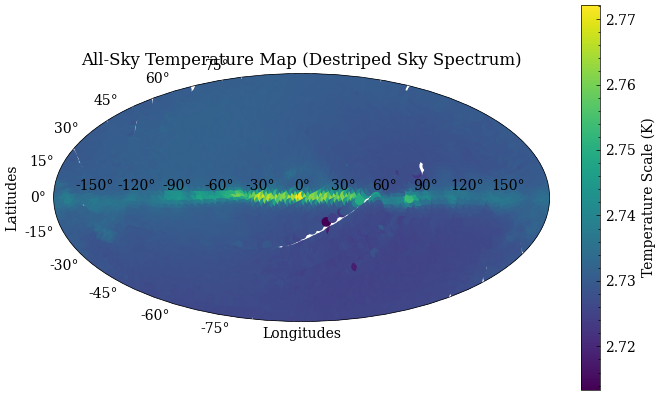

In [16]:
plt.figure(figsize=(8,5))
plt.subplot(111,projection='aitoff')
plt.title('All-Sky Temperature Map (Destriped Sky Spectrum)')
plt.scatter(longitude_rad,latitude_rad,c = np.array(Pixel_data['Temperature']))
plt.xlabel('Longitudes')
plt.ylabel('Latitudes')
plt.colorbar(label='Temperature Scale (K)')

It is inferred that the all-sky spectrum recieved alone does not accurately represen the Microwave Background. So, we use a multitude of techniques to filter the data, trying to gather the best result possible.

# 1. Cosmic Dust removal 

The destriped data which we used is highly contaminated ,the absolute intensities are disrupted by the emission of EM radiation due to many galactic and other entities ,a major set of entities of that sort is the cosmic dust . our goal is to remove all the dust components from the destriped sky spectra

In [17]:
final_data = [i*0 for i in range(0,6067)]

dust_clear_data = destriped_data['SPECTRUM'] - dust_data['SPECTRUM']

for i in range(len(dust_clear_data)):
    final_data[i] = dust_clear_data[i][:43:] + final_data[i]

Pixel_data=get_Temperature(frequency,final_data)

print(Temperature_value(Pixel_data['Temperature'],Pixel_data['Uncertainty']))
print(len(final_data))



Temperature attained is = 2.727816 +- 0.000242 K 

None
6067


As a control setup, we calculate the temperature for the original data (without dust removal)

In [18]:
final_data_control = [i*0 for i in range(0,6067)]

for i in range(len(destriped_data['SPECTRUM'])):
    final_data_control[i] = destriped_data['SPECTRUM'][i][:43:] + final_data_control[i]

Pixel_data_control = get_Temperature(frequency,final_data_control)

print(Temperature_value(Pixel_data_control['Temperature'],Pixel_data_control['Uncertainty']))

Temperature attained is = 2.729854 +- 0.002808 K 

None


# 2. Galactic cutting

The galaxy emission(em waves emitted by stars and other objects in and around the galaxy) causes our cmb temperature value to deviate as cmb is independent of the presence of any physical object in present universe which can emit em radiation hence to obtain better approximation of cmb we consider removing those pixels from our working set of pixels which have huge galactic contamination in their data.

In [19]:
latitude = destriped_data['GAL_LAT']
longitude = destriped_data['GAL_LON']
Intensity_observed = final_data
Intensity_observed_control = final_data_control

i=[]
accepted_spectrum=[]
accepted_spectrum_control =[]
accepted_latitude=[]
accepted_longitude=[]


for i in range(0,len(latitude)):
    
    if latitude[i] < 20:
    
        if latitude[i] > -20:
            continue
    
        else:
            accepted_spectrum.append(Intensity_observed[i])
            accepted_spectrum_control.append(Intensity_observed_control[i])
            accepted_latitude.append(latitude[i])
            accepted_longitude.append(longitude[i])
    
    if latitude[i]> 20:
        accepted_spectrum.append(Intensity_observed[i])
        accepted_spectrum_control.append(Intensity_observed_control[i])
        accepted_latitude.append(latitude[i])
        accepted_longitude.append(longitude[i])

spectrum_cut=np.array(accepted_spectrum)
spectrum_cut_control = np.array(accepted_spectrum_control)
spectrum_cut.shape
spectrum_cut_control.shape

(4005, 43)

In [20]:
print(len(spectrum_cut))

4005


In [21]:
longitude=[]

for i in accepted_longitude:
    
    if i > 180:
        longitude.append(i-360)
    
    else:
        longitude.append(i)

accepted_latitude=np.array(accepted_latitude)
accepted_longitude=np.array(longitude)

In [22]:
# THIS SUB_CODEBLOCK IS FOR EXPERIMENTAL DATASET
Pixel_cut = get_Temperature(frequency,spectrum_cut)

print(Temperature_value(Pixel_cut['Temperature'],Pixel_cut['Uncertainty']))

'''.........................................................................................................................................................................'''


# THIS SUB-CODEBLOCK IS FOR CONTROL DATASET
Pixel_cut_control = get_Temperature(frequency,spectrum_cut_control)

print(Temperature_value_control(Pixel_cut_control['Temperature'],Pixel_cut_control['Uncertainty']))




Temperature attained is = 2.727780 +- 0.000196 K 

None
Temperature_control attained is = 2.728380 +- 0.000855 K 

None


# 3. Sigma Reduction Algorithm

The cut along the galactic equator as done above seems not adequate,there is still deviation we would like to get rid of. Any pixel with more than $5\sigma$ deviation( where $\sigma$ is the RMS value of final temperatures computed till now) from the average should be dropped from the analysis

In [23]:
avg_temperature = np.mean(Pixel_cut['Temperature'])
sigma_corrected_data=[]
sigma_corrected_uncertainty = np.zeros(4005)
accepted_longitude.tolist()
accepted_latitude.tolist()
final_latitude = []
final_longitude = []

sigma = np.std(Pixel_cut['Temperature'])

for i in range(len(Pixel_cut['Temperature'])):
    
    point_max=avg_temperature +5*sigma
    point_min=avg_temperature -5*sigma
    
    if Pixel_cut['Temperature'][i] < point_max:
    
        if Pixel_cut['Temperature'][i]>=point_min:
            sigma_corrected_data.append(Pixel_cut['Temperature'][i])
            sigma_corrected_uncertainty[i] = Pixel_cut['Uncertainty'][i]
            final_longitude.append(accepted_longitude[i])
            final_latitude.append(accepted_latitude[i])

sigma_corrected_data=np.array(sigma_corrected_data)
sigma_corrected_uncertainty = np.array(sigma_corrected_uncertainty)


sigma_corrected_data_control=[]
sigma_corrected_uncertainty_control = []
final_latitude_control = []
final_longitude_control = []

sigma_control = np.std(Pixel_cut_control['Temperature'])

for i in range(len(Pixel_cut_control['Temperature'])):

    point_max=avg_temperature +5*sigma_control
    point_min=avg_temperature -5*sigma_control

    if Pixel_cut_control['Temperature'][i] < point_max:

        if Pixel_cut_control['Temperature'][i]>=point_min:

            sigma_corrected_data_control.append(Pixel_cut_control['Temperature'][i])
            sigma_corrected_uncertainty_control.append(Pixel_cut_control['Uncertainty'][i])
            final_longitude_control.append(accepted_longitude[i])
            final_latitude_control.append(accepted_latitude[i])

sigma_corrected_data_control=np.array(sigma_corrected_data_control)
sigma_corrected_uncertainty_control = np.array(sigma_corrected_uncertainty_control)



The final Temperature values of experimental dataset and control dataset

In [24]:
print(Temperature_value(sigma_corrected_data,sigma_corrected_uncertainty))
print(Temperature_value_control(sigma_corrected_data_control,sigma_corrected_uncertainty_control))

Temperature attained is = 2.727780 +- 0.000196 K 

None
Temperature_control attained is = 2.728380 +- 0.000855 K 

None


These 2 codeblocks are required to attain a well approximate graph of the relation between intensities and frequencies

In [25]:
spectrum_cut_transpose = spectrum_cut.T
spectrum_cut_transpose_control = spectrum_cut_control.T

612187292000.0

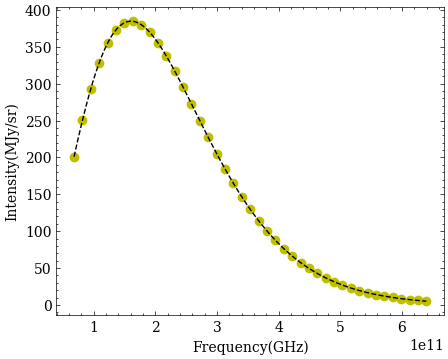

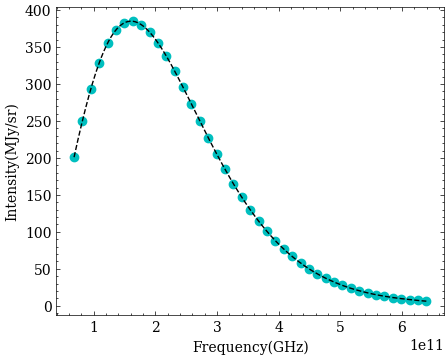

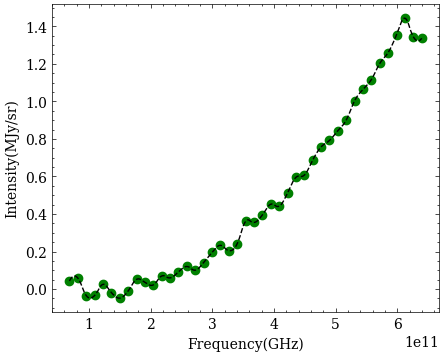

In [61]:
# this sub code block is for finding the intensity vs frequency map of experimental dataset
mean_list = [i*0 for i in range(43)]
for i in range(len(spectrum_cut_transpose)):
    mean_list[i] = np.mean(spectrum_cut_transpose[i]) + mean_list[i]    

x = np.array(frequency)
f = interp1d(frequency,mean_list,kind = 'quadratic')
x_dense = np.linspace(frequency[0],frequency[42],1000)
y_dense = f(x_dense)

plt.figure(figsize=(5,4))
plt.plot(frequency,mean_list,'yo')
plt.plot(x_dense,y_dense,'k--')
plt.xlabel('Frequency(GHz)')
plt.ylabel('Intensity(MJy/sr)')



# this sub code block is for finding the intensity vs frequency map of control dataset
mean_list_control = [i*0 for i in range(43)]
for i in range(len(spectrum_cut_transpose_control)):
    mean_list_control[i] = np.mean(spectrum_cut_transpose_control[i]) + mean_list_control[i]    

x = np.array(frequency)
f_control = interp1d(frequency,mean_list_control,kind = 'quadratic')
x_dense_control = np.linspace(frequency[0],frequency[42],1000)
y_dense_control = f_control(x_dense)

plt.figure(figsize=(5,4))
plt.plot(frequency,mean_list_control,'co')
plt.plot(x_dense_control,y_dense_control,'k--')
plt.xlabel('Frequency(GHz)')
plt.ylabel('Intensity(MJy/sr)')

# this sub code block is for finding the difference between the intensity values of experimental dataset and control dataset 
mean_list_diff = [i*0 for i in range(43)]
for i in range(len(spectrum_cut_transpose_control)):
    mean_list_diff[i] = -np.mean(spectrum_cut_transpose[i]) + np.mean(spectrum_cut_transpose_control[i]) + mean_list_diff[i]    

x = np.array(frequency)
f_control = interp1d(frequency,mean_list_diff,kind = 'quadratic')
x_dense_control = np.linspace(frequency[0],frequency[42],1000)
y_dense_control = f_control(x_dense)

plt.figure(figsize=(5,4))
plt.plot(frequency,mean_list_diff,'go')
plt.plot(x_dense_control,y_dense_control,'k--')
plt.xlabel('Frequency(GHz)')
plt.ylabel('Intensity(MJy/sr)')

frequency[mean_list_diff.index(np.max(mean_list_diff))]

Now, we plot temperature maps to compare both the data sets

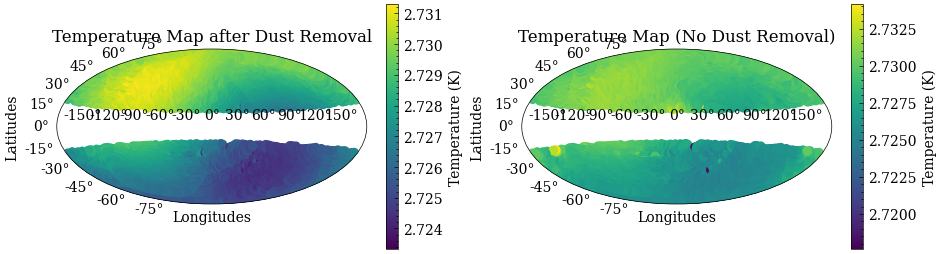

In [27]:
longitude=[]
for i in final_longitude:
    if i > 180:
        longitude.append(i-360)
    else:
        longitude.append(i)
latitude=final_latitude

latitude_rad=np.pi*np.array(final_latitude)/180
longtitude_rad=np.pi*np.array(final_longitude)/180

fig=plt.figure(figsize=(11,7))
fig.add_subplot(221,projection='aitoff')
plt.title('Temperature Map after Dust Removal')
plt.scatter(longtitude_rad,latitude_rad,c=sigma_corrected_data)
plt.xlabel('Longitudes')
plt.ylabel('Latitudes')
plt.colorbar(label='Temperature (K)')

longitude=[]
for i in final_longitude_control:
    if i > 180:
        longitude.append(i-360)
    else:
        longitude.append(i)
latitude=final_latitude_control
latitude_rad_control=np.pi*np.array(final_latitude_control)/180
longtitude_rad_control=np.pi*np.array(final_longitude_control)/180

#fig =plt.figure(figsize=(4,2))
fig.add_subplot(222,projection='aitoff')
plt.title('Temperature Map (No Dust Removal)')
plt.scatter(longtitude_rad_control,latitude_rad_control,c=sigma_corrected_data_control)
plt.xlabel('Longitudes')
plt.ylabel('Latitudes')
plt.colorbar(label='Temperature (K)')

Further, we also plot the temperature map for the Cosmic Dust to check it's characteristics

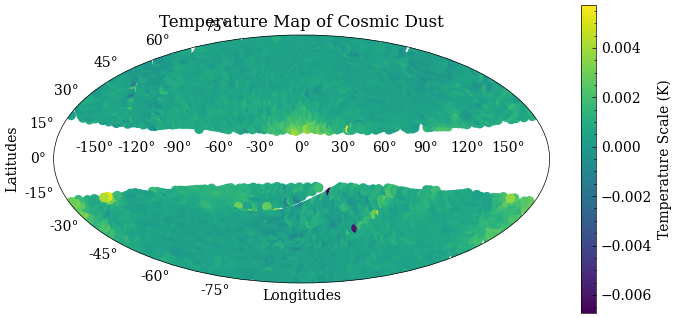

In [28]:
# This subcode _block is only for dust
longitude=[]
for i in final_longitude:
    if i > 180:
        longitude.append(i-360)
    else:
        longitude.append(i)
latitude=final_latitude
latitude_rad=np.pi*np.array(final_latitude)/180
longtitude_rad =np.pi*np.array(final_longitude)/180
plt.figure(figsize=(8,4))
plt.subplot(111,projection='aitoff')
plt.title('Temperature Map of Cosmic Dust')
plt.scatter(longtitude_rad,latitude_rad,c= -np.array(Pixel_cut['Temperature'])+np.array(Pixel_cut_control['Temperature']))
plt.xlabel('Longitudes')
plt.ylabel('Latitudes')
plt.colorbar(label='Temperature Scale (K)')

# Calculating Velocity of our Solar System

The apparent background temperature of an observer moving with a velocity v with respect to the background radiation is of the form:
$$T_{obs}= T_{cmbr}\frac{\sqrt{1-(\frac{v}{c})}}{1-(\frac{v}{c})cos\theta}
= T_{cmbr}(1+\frac{v}{c}cos\theta)$$

First, we need to find the values $cos\theta$ from every pixel of the sky to the point of the highest temperature 

In [29]:
def deg_rad(deg):
    rad = np.pi * deg/180
    return rad
def costheta(l1,b1,l2,b2):
    l1=deg_rad(l1)
    b1=deg_rad(b1)
    l2=deg_rad(l2)
    b2=deg_rad(b2)
    a,b,c = np.zeros(len(l1)), np.zeros(len(l1)), np.zeros(len(l1))
    for i in range(len(l1)):
        a[i]=np.cos(b1[i])*np.cos(l1[i])*np.cos(b2)*np.cos(l2)
        b[i]=np.cos(b1[i])*np.sin(l1[i])*np.cos(b2)*np.sin(l2)
        c[i]=np.sin(b1[i])*np.sin(b2)
    return a+b+c

Plotting temperature map of the CMB Dipole:

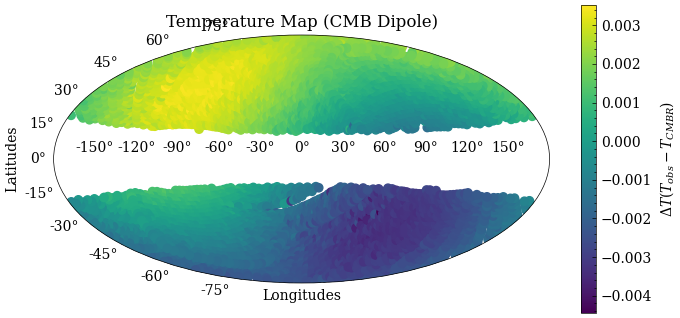

In [30]:
#This sub-code block is for the dust removed data
root_mean_square_temperature_final = root_mean_square(sigma_corrected_data)
dipole_data = sigma_corrected_data - root_mean_square_temperature_final
longitude=[]
for i in final_longitude:
    if i > 180:
        longitude.append(i-360)
    else:
        longitude.append(i)
latitude=final_latitude
latitude_rad=np.pi*np.array(final_latitude)/180
longtitude_rad=np.pi*np.array(final_longitude)/180
plt.figure(figsize=(8,4))
plt.subplot(111,projection='aitoff')
plt.title('Temperature Map (CMB Dipole)')
plt.scatter(longtitude_rad,latitude_rad,c=dipole_data)
plt.xlabel('Longitudes')
plt.ylabel('Latitudes')
plt.colorbar(label='$\Delta T(T_{obs}-T_{CMBR})$')

The maximum value of the dipole corresponds to its hot pole, we choose this pixel to measure $\theta$ from 

In [31]:
dipole_data = dipole_data.tolist()
dipole_data.index(np.max(dipole_data))

2157

In [32]:
index = dipole_data.index(np.max(dipole_data))
l1 = final_longitude[index]
b1 = final_latitude[index]
cos_theta = costheta(np.array(final_longitude) , np.array(final_latitude), l1, b1)

# Chi-Squared($\chi^2$) analysis

To find the velocity and it's tolerance, we turn back to a well-known data analysis technique. This is used to calculate best-fit parameters(A and B) using linear regression

$$\chi^2 = \sum{\frac{(y_i-Ax_i-B)^2}{\sigma^2_i}}$$

In [33]:
y = np.array(sigma_corrected_data)
x = 2.727755*np.array(cos_theta)/c
yerr = np.array(sigma_corrected_uncertainty)

Opening the summation into the terms of the equation, we get:
$$\chi^2 = \sum{\frac{y^2_i}{\sigma^2_i}}   - 2A \sum{\frac{y_ix_i}{\sigma^2_i}}  - 2B\sum{\frac{y_i}{\sigma^2_i}} - 2AB \sum{\frac{x_i}{\sigma^2_i}} + A^2 \sum{\frac{x^2_i}{\sigma^2_i}} + B^2 \sum{\frac{1}{\sigma^2_i}}$$

To save space, we redefine those sums and rewrite as

$$\chi^2 = [S_{yy}] -2A[S_{xy}] -2B[Sy] -2AB[S_x] +A^2[S_{xx}] +B^2[S_0] $$

In [34]:
s_yy=sum(y**2/yerr**2)
s_xx=sum(x**2/yerr**2)
s_0=np.sum(1/yerr**2)
s_xy=sum( (y*x) /yerr**2)
s_y=sum(y/yerr**2)
s_x=sum(x/yerr**2)

By completing the square and exchanging the six parameters(the S's) for six new parameters $A^*,\sigma_A,B^*,\sigma_B,\rho$ and $\chi^2_{min}$:

$$\chi^2 = \frac{(A-A^*)^2}{\sigma_A^2} + \frac{(B-B^*)^2}{\sigma_B^2} + 2\rho\frac{(A-A^*)(B-B^*)}{\sigma_A \sigma_A} + \chi^2_{min}$$

Of course, you recognize this as the equation of an elliptic paraboloid! This means that in place of a parabola along the
A axis we now have a (bowl shaped) three-dimensional paraboloid hovering above the A-B plane. The best fit parameters A* and B* are located at the minimum point of the paraboloid, where $\chi^2=\chi^2_{min}$

Solving both euqtions in terms of the new parameters, we get:

$$A^* = \frac{S_0 . S_{xy} - S_x . S_y}{S_0 . S_{xx} - S^2_x} $$
$$\sigma_A = \frac{1}{\sqrt{S_{xx}}} $$
$$B^* = \frac{S_y . S_{xx} - S_x . S_{xy}}{S_0 . S_{xx} - S^2_x} $$
$$\sigma_B = \frac{1}{\sqrt{S_{0}}} $$
$$\rho = \frac{S_x}{\sqrt{S_{xx} . S_0}}   $$
$$\chi^2_{min} = \frac{S_0 . S^2_{xy} - 2S_x.S_y . S_xy  + S^2_y . S_{xx}}{S^2_x - S_0 . S_xx} +S_{yy}     $$

In [35]:
from numpy import *

A_best = (s_0*s_xy - s_x*s_y)/(s_0*s_xx - s_x**2)
sigma_A = 1/np.sqrt(s_xx);
B_best = (s_y*s_xx - s_x*s_xy)/(s_0*s_xx - s_x**2)
sigma_B = 1/np.sqrt(s_0);
rho = s_x/np.sqrt(s_xx*s_0);
minchi2 = ((s_0*s_xy**2 - 2*s_x*s_y*s_xy + s_y**2*s_xx)/(s_x**2 - s_0*s_xx)) + s_yy

Creating a `meshgrid` for plotting the parameters

In [36]:

A_interval = 1.1*(np.sqrt(6.17*sigma_A**2/(1-rho**2)));
B_interval = 1.1*(np.sqrt (6.17*sigma_B**2/(1-rho**2)));

# create parameter grid
#a = np.linspace(A_best-A_interval, A_best+A_interval)
a = np.linspace(382000,390000)
b = np.linspace(2.72775, 2.72777)
A,B = np.meshgrid(a,b)

In [37]:

# chi2=(S1)+ (A**2)*(S2) + (B**2)*(S3) - 2*A*S4 - 2*B*S5 + 2*A*B*S6
chi2 = s_yy + (A**2)*s_xx + (B**2)*s_0 - 2*A*s_xy - 2*B*s_y + 2*A*B*s_x;

Plotting a contour graph with $68$% and $95$% confidence levels

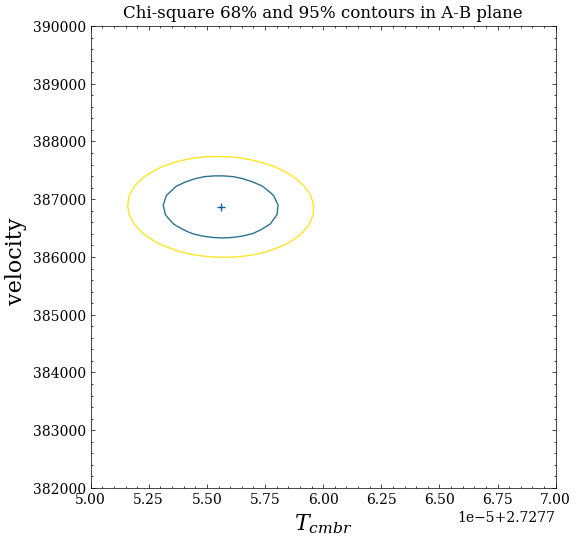

In [38]:
plt.figure(figsize=(6,6))
levels = [minchi2,minchi2+2.3,minchi2+6]
Z=plt.contour(B,A,chi2,levels)
#plt.clabel(Z,inline=1, fontsize=5)
plt.plot(B_best,A_best,'+')
plt.xlabel('$T_{cmbr}$',fontsize=16)
plt.ylabel('velocity ',fontsize=16)
plt.title('Chi-square 68% and 95% contours in A-B plane')
plt.show()

## Finding the direction of motion

Again, it is done by least square regression but now only 1 paramter at a time. We choose a range of longitudes/latitudes and calculate $\cos \theta$ for every single one, varying it for constant velocity and $T_{CMBR}$. Producing the following graphs 

In [39]:
Temperature = sigma_corrected_data
sigma = sigma_corrected_uncertainty

In [40]:
a=386866/c
chisq1=np.zeros(500)
lon=np.linspace(258,270,num=500)

coos=np.zeros((500,4005))
for i in range(500):
    coos[i]=costheta(np.array(final_longitude),np.array(final_latitude),lon[i],final_latitude[2157])

for i in range(chisq1.size):
    k_flag = Temperature - 2.727755*(1+a*coos[i])
    che=(k_flag/sigma)**2
    dhe=np.sum(che)
    chisq1[i]=dhe

chisq2=np.zeros(500)
lat=np.linspace(45,50,num=500)

coos=np.zeros((500,4005))
for i in range(500):
    coos[i]=costheta(np.array(final_longitude),np.array(final_latitude),264-360,lat[i])

for i in range(chisq2.size):
    k_flag = Temperature - 2.727755*(1+a*coos[i])
    che=(k_flag/sigma)**2
    dhe=np.sum(che)
    chisq2[i]=dhe


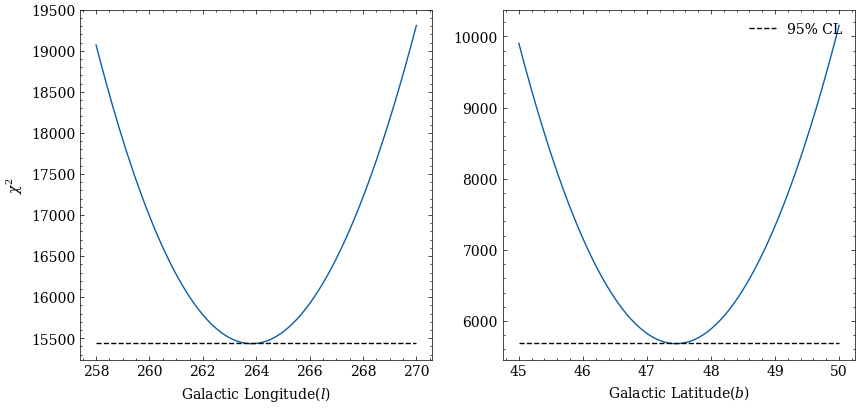

In [41]:
fig=plt.figure(figsize=(10,10))
fig.add_subplot(221)
plt.plot(lon,chisq1)
plt.plot(lon,np.full(fill_value=np.min(chisq1)+4,shape=500),'k--',label='95% CL')
#plt.plot(np.full(fill_value=()),np.full())
plt.xlabel('Galactic Longitude($l$)')
plt.ylabel('$\chi^2$')

fig.add_subplot(222)
plt.plot(lat,chisq2)
plt.plot(lat,np.full(fill_value=np.min(chisq2)+4,shape=lat.size),'k--',label='95% CL')
plt.xlabel('Galactic Latitude($b$)')
plt.legend(loc='upper right')

To find the standard errors in these calculations, it is reminded that the 95% confidence level corresponds to $\chi^2_{min} + 4$, thus both error bars are calculated and their average is noted. 

To calculate where the $\chi^2_{min} + 4$ intersects the graph, we've used `np.argwhere(), np.diff() and np.sign()` 

In [44]:
def find_sigma(x,chi2):
    sigma=np.zeros(2)
    idx= np.argwhere(np.diff(np.sign((np.min(chi2)+4)-chi2))).flatten()
    sigma[0] = np.argmin(chi2)-x[idx[0]]
    sigma[1] = x[idx[1]]-np.argmin(chi2)
    return np.mean(sigma)

# Results:

In [45]:
print(f'''
The Velocity of the solar system with respect to the CMB is {A_best/1e3:.4f} ± {2*sigma_A/1e3:.4f} km/s (95% CL)
The Temperature of the CMB across the whole sky is {B_best:.6f} ± {2*sigma_B:.6f} K (95% CL)
The direction of the motion in galactic coordinates (l,b) is ({lon[np.argmin(chisq1)]:.4f} ± {find_sigma(lon,chisq1):.4f},{lat[np.argmin(chisq2)]:.4f} ± {find_sigma(lat,chisq2):.4f}) (95% CL)''')


The Velocity of the solar system with respect to the CMB is 386.8660 ± 0.7149 km/s (95% CL)
The Temperature of the CMB across the whole sky is 2.727756 ± 0.000003 K (95% CL)
The direction of the motion in galactic coordinates (l,b) is (263.8196 ± 0.1924,47.4549 ± 0.0752) (95% CL)


## OFFICIAL VALUES ACCORDING TO COBE DATA - 
CBR_TEMP=  $2.727754$ /  CMBR temperature, in K                                          
DIP_LON =  $264.98$ /  Dipole galactic longitude, in deg             
DIP_LAT =  $47.92$ /  Dipole galactic latitude, in deg     

(courtesy: file header of the CMB_TEMPERATURE_MAP DATA, FIRAS official website)
